<a href="https://colab.research.google.com/github/SweathaPappachan/DTTE-SweathaPappachan/blob/main/DTTE_Tutorial_28_Applying_Bayes_Classifiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Machine Learning: Lab 3 - Applying Bayes Classifiers

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/drive/1TuDbIyso6irdyBFgaHRpC-PxUICWPHcS?usp=sharing"><img height="32px" src="https://colab.research.google.com/img/colab_favicon.ico" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/Foundations-in-Modern-Machine-Learning/course-contents/tree/main/Bayesian/"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>
<br>
<br>
<br>

In [1]:
import os
import json
import re

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as pg

import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
!wget https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
plt.style.use('ggplot')

--2023-10-18 07:31:59--  https://raw.githubusercontent.com/Foundations-in-Modern-Machine-Learning/course-contents/main/Bayesian/data/arxiv-paper-data.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72422946 (69M) [text/plain]
Saving to: ‘arxiv-paper-data.json’

arxiv-paper-data.js 100%[===================>]  69.07M   149MB/s    in 0.5s    

2023-10-18 07:32:00 (149 MB/s) - ‘arxiv-paper-data.json’ saved [72422946/72422946]



Let's make a few assumptions to come up with our first general model for classification:
* The different features contribute equally to the result
* The features are independent

## Bayes Classifiers in Scikit Learn

### Simple 1-D Classfication using Naive Bayes in Continuous Space

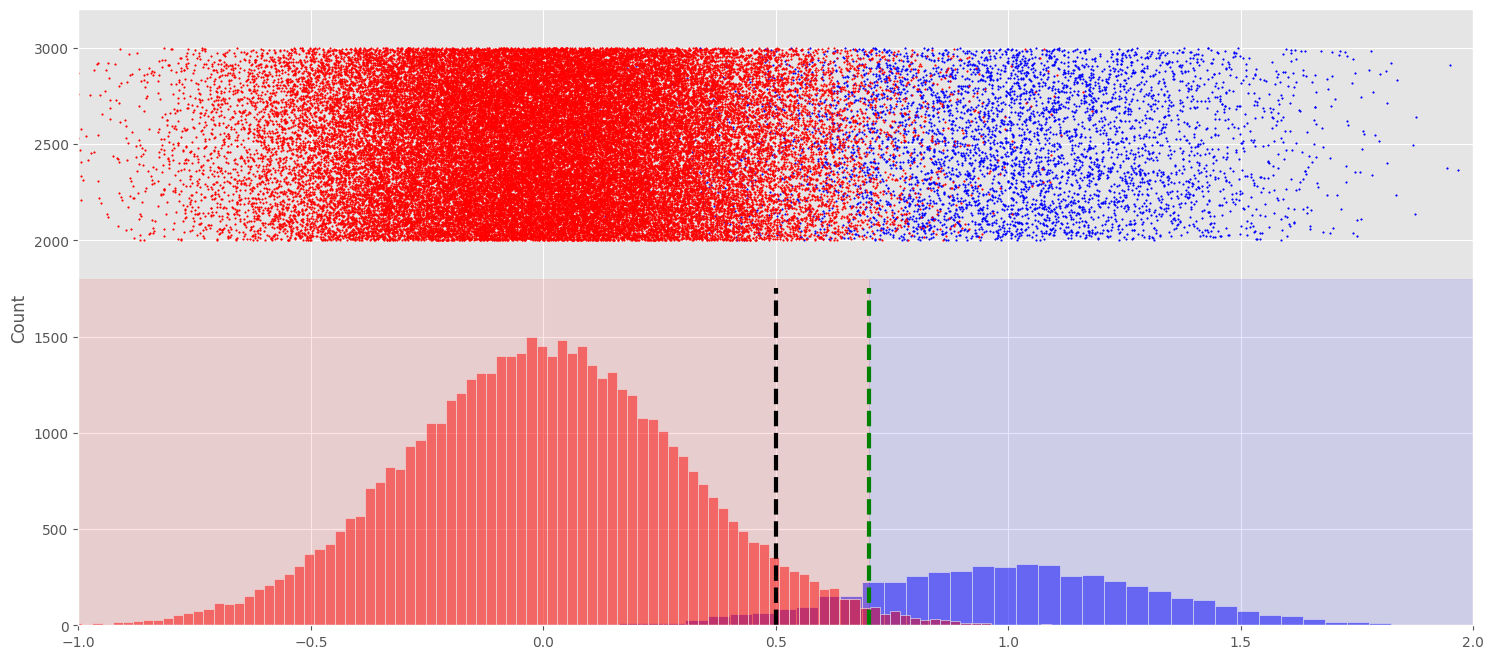

In [3]:
fig, ax = plt.subplots(figsize=(18, 8))
x1 = np.random.normal(1.0, 0.3, size=5000)
x2 = np.random.normal(0.0, 0.3, size=50000)
x = np.concatenate([x1, x2])
y = np.concatenate([np.zeros(len(x1)), np.ones(len(x2))])
sns.histplot(x1, color='blue', alpha=0.5, ax=ax)
sns.histplot(x2, color='red', alpha=0.5, ax=ax)
ax.fill_between(np.linspace(-1.0, 0.7, 100), 0, 1800,  color='r', alpha=0.1)
ax.fill_between(np.linspace(0.7, 2.0, 100), 0, 1800,  color='b', alpha=0.1)
ax.vlines(0.5, 0, 1750, color="k", linestyles="--", lw=3)
ax.vlines(0.7, 0, 1750, color="g", linestyles="--", lw=3)
ax.scatter(x1, [np.random.randint(2000, 3000) for _ in x1], color='b', s=1)
ax.scatter(x2, [np.random.randint(2000, 3000) for _ in x2], color='r', s=1)
ax.set_xlim(-1.0, 2.0)
ax.set_ylim(0, 3200)
plt.show()

In [4]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
x_reshaped = x.reshape(1, -1)
print(x_reshaped.shape)

(1, 55000)


## Gaussian Bayes Predictor on Predicting Flowers

### Predictors in Scikit Learn

In [5]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

X, y = load_iris(return_X_y=True)
X = X[:, [2, 3]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB()

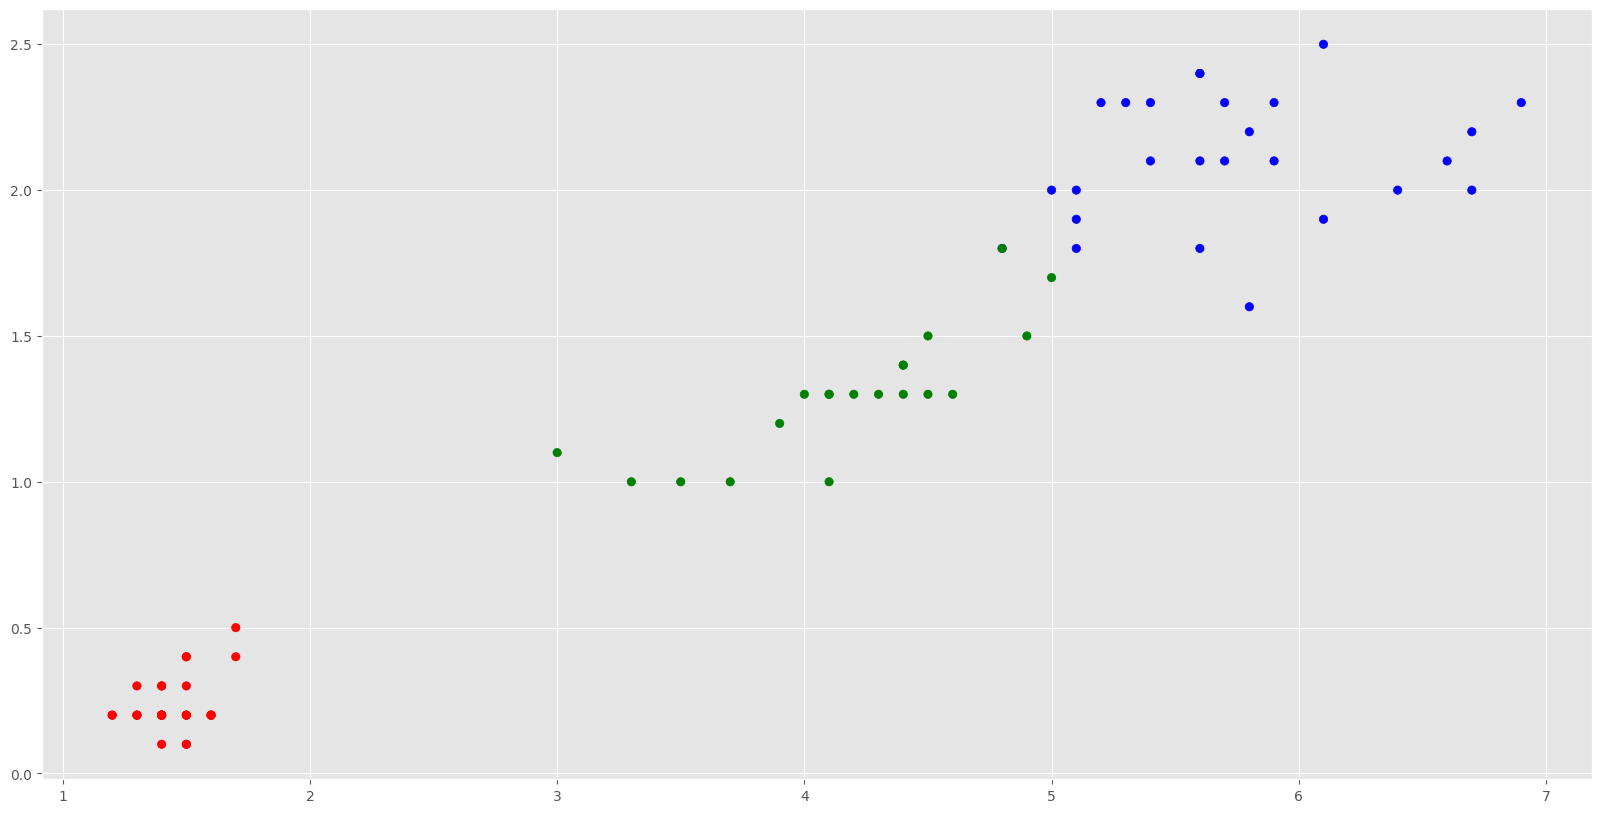

In [6]:
plt.figure(figsize=(20, 10))
color_scheme = ['red', 'green', 'blue']
plt.scatter(X_train[:, 0], X_train[:, 1], c=[color_scheme[idx] for idx in y_train])
plt.show()

### Visualizing the Decision Surface

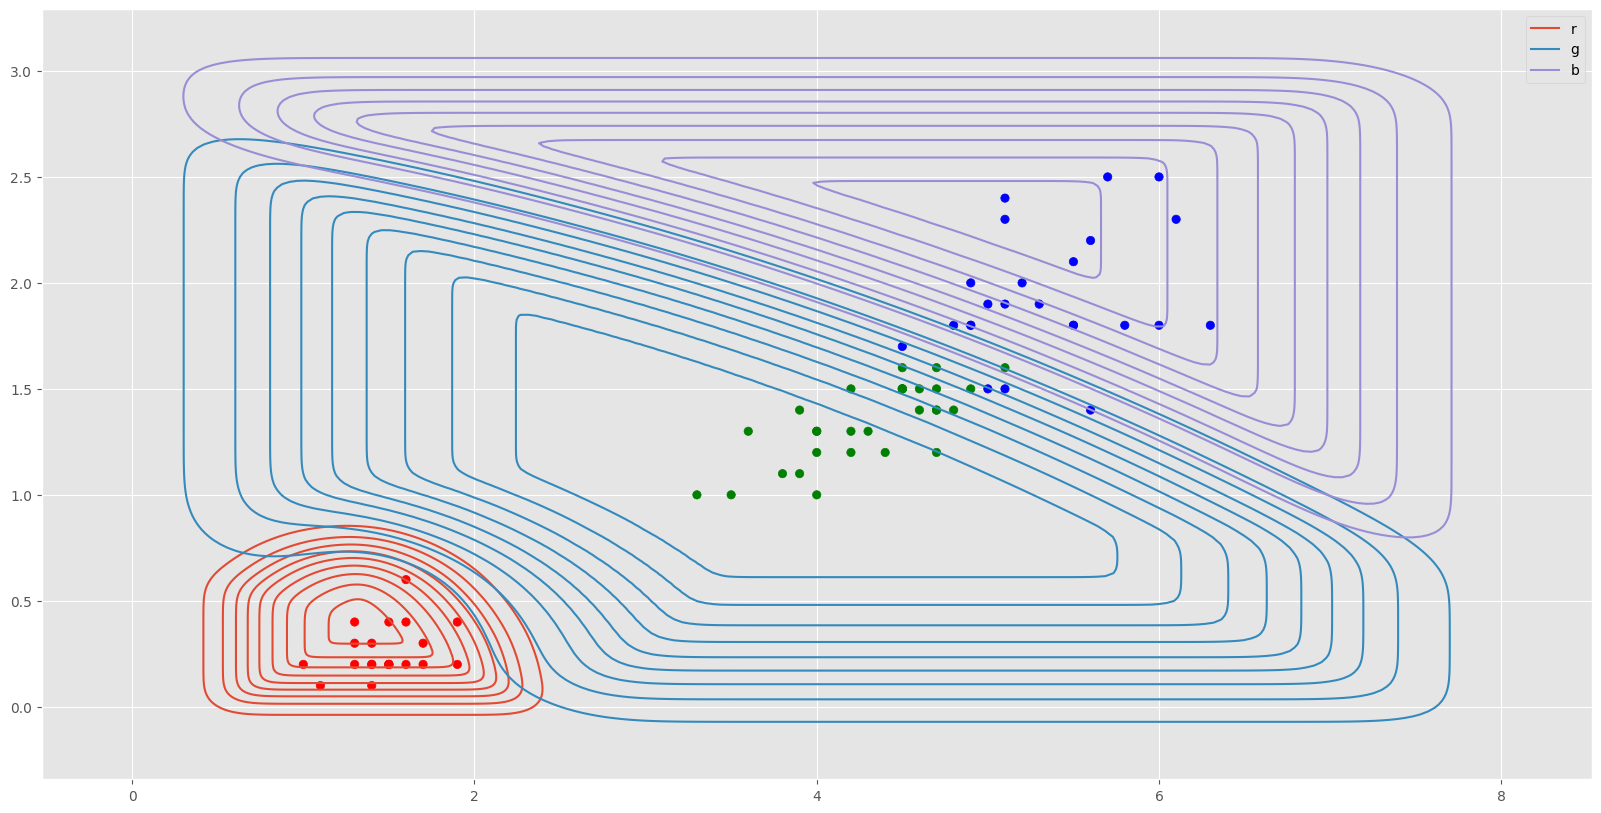

In [7]:
plt.figure(figsize=(20, 10))
X1_scan, X2_scan = np.meshgrid(np.linspace(0.5, 7.5, 250), np.linspace(0.0, 3.0, 250))
X_scan = np.stack([np.reshape(X1_scan, -1), np.reshape(X2_scan, -1)], axis=-1)
predictions = gnb.predict(X_scan)
color_map = ['r', 'g', 'b']
plt.scatter(x=X_test[:, 0], y=X_test[:, 1], c=[color_map[x] for x in y_test])
sns.kdeplot(x=X_scan[:, 0], y=X_scan[:, 1], hue=[color_map[x] for x in predictions], fill=False)
plt.show()

## Bayes on Text - Classifying papers at Arxiv

### Data Cleaning and Preprocessing

In [8]:
arxiv_df = pd.read_json(open("arxiv-paper-data.json", 'r'))
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: json.loads(x.replace("\'", "\"").replace("None", "\"None\""))[0]['term'].split('.')[0])
arxiv_df["tag"] = arxiv_df["tag"].apply(lambda x: 'physics' if x in ['physics', 'quant-ph', 'astro-ph', 'hep-ex', 'hep-ph', 'hep-lat', 'hep-th', 'nucl-th'] else x)
arxiv_df = arxiv_df.drop(["day", "month", "link", "author"], axis=1)

In [9]:
SAMPLES_COMP = 3500 #@param {type: "slider", min: 1000, max: 4500}
SAMPLES_STAT = 2500 #@param {type: "slider", min: 1000, max: 4500}
WORD_COUNT_THRESHOLD = 1  #@param {type: "slider", min: 1, max: 500}
WORD_LENGTH_THRESHOLD = 8  #@param {type: "slider", min: 4, max: 20}

In [10]:
df = pd.concat([arxiv_df[arxiv_df['tag'] == 'cs'].sample(SAMPLES_COMP, replace=False),
                arxiv_df[arxiv_df['tag'] == 'stat'].sample(SAMPLES_STAT, replace=False)]).sample(frac=1)
df['keywords'] = df.apply(lambda x: [word.lower() for word in re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', x.summary + ' ' + x.title)).split()
                                     if len(word) > WORD_LENGTH_THRESHOLD and not re.search('(\d|\(|\))', word)], axis=1)
train_df, test_df = df.iloc[:int(len(df) * 0.8)], df.iloc[int(len(df) * 0.8):]

train_df

,id,summary,tag,title,year,keywords
29833,1710.08014v1,We model the photo cropping problem as a casca...,cs,Deep Cropping via Attention Box Prediction and...,2017,"[attention, regression, aesthetic, classificat..."
20061,1404.7173v1,A {\it dynamic reasoning system} (DRS) is an a...,cs,Nonmonotonic Reasoning as a Temporal Activity,2014,"[reasoning, adaptation, conventional, explicit..."
39733,1703.03098v2,3D scene understanding is important for robots...,cs,DA-RNN: Semantic Mapping with Data Associated ...,2017,"[understanding, important, meaningful, underst..."
6180,1609.00845v1,"In graph-based active learning, algorithms bas...",stat,Graph-Based Active Learning: A New Look at Exp...,2016,"[algorithms, minimization, empirical, performa..."
1511,1803.03827v1,The past few years have witnessed renewed inte...,cs,Face2Text: Collecting an Annotated Image Descr...,2018,"[witnessed, interface, intensively, automatica..."
...,...,...,...,...,...,...
28167,1705.08273v1,Quantitative computed tomography (QCT) is a st...,cs,A New 3D Segmentation Technique for QCT Scans ...,2017,"[quantitative, tomography, determine, traditio..."
6730,1705.08741v2,Background: Deep learning models are typically...,stat,"Train longer, generalize better: closing the g...",2017,"[background, typically, stochastic, estimated,..."
23062,1803.02432v1,We develop theory for nonlinear dimensionality...,stat,"On Nonlinear Dimensionality Reduction, Linear ...",2018,"[nonlinear, dimensionality, reduction, develop..."
21914,1502.05313v2,Annealed importance sampling (AIS) is a common...,stat,Variational Optimization of Annealing Schedules,2015,"[importance, algorithm, partition, functions, ..."


In [11]:
df['keywords']

29833    [attention, regression, aesthetic, classificat...
20061    [reasoning, adaptation, conventional, explicit...
39733    [understanding, important, meaningful, underst...
6180     [algorithms, minimization, empirical, performa...
1511     [witnessed, interface, intensively, automatica...
                               ...                        
27472    [classification, distortions, distorted, outpe...
4958     [probabilistic, framework, adaptation, generat...
10594    [statistical, procedures, computationally, inc...
5923     [designing, introduced, approximate, averaging...
21955    [allocating, allocations, continuous, allocati...
Name: keywords, Length: 6000, dtype: object

### Learning Probability Distributions

In [12]:
from collections import defaultdict
dictionary = defaultdict(lambda: [0, 0])
for desc, tag in zip(df['keywords'], df['tag']):
    for word in set(desc):
        if tag == 'cs':
            dictionary[word][0] += 1
        else:
            dictionary[word][1] += 1

print("We have a dictionary of", len(dictionary), "words.")

words, counts_cs, counts_stat = [], [], []
for word, count in dictionary.items():
    if count[0] + count[1] > WORD_COUNT_THRESHOLD:
        words.append(word)
        counts_cs.append(count[0])
        counts_stat.append(count[1])
print("Out of those", len(words), f"have over {WORD_COUNT_THRESHOLD} occurances")

fig = pg.Figure([pg.Bar(x=words[:200], y=counts_cs[:200]),
                 pg.Bar(x=words[:200], y=counts_stat[:200])])
fig.update_layout(title_text=f'Some random words and the frequency plot of those with over {WORD_COUNT_THRESHOLD} occurances')
fig.show()

We have a dictionary of 8792 words.
Out of those 4556 have over 1 occurances


For each word, for both the subjects, we can apply Bayes rule.

$$P\bigg(\frac{\text{subject}}{\text{word}}\bigg) = P\bigg(\frac{\text{word}}{\text{subject}}\bigg) \times \frac{P(\text{subject})}{P(\text{word})}$$

### Computing the resultant probabilities

In [13]:
prior = np.array([train_df["tag"].value_counts()["cs"], train_df["tag"].value_counts()["stat"]]) / len(train_df)
evidence = np.array([counts_cs / train_df["tag"].value_counts()["cs"], counts_stat / train_df["tag"].value_counts()["stat"]]).T
likelihood = (np.array(counts_cs) + np.array(counts_stat)) / len(train_df)

prior.shape, likelihood.shape, evidence.shape

((2,), (4556,), (4556, 2))

In [14]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(
        np.multiply(this_counts.reshape(-1, 1), evidence), likelihood.reshape(-1, 1))) + 0.001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.805


### Visualizing a few examples

In [15]:
def explain(example):
    from IPython.display import HTML
    title, desc, answer = example["title"], example["summary"], example["tag"]
    html = ""
    title = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', title)))
    desc = re.sub(' +', ' ', re.sub('[^(\w| )]', '', re.sub('(-|_|\n)', ' ', desc)))
    for text in [title, desc]:
        for word in text.split():
            idx = words_to_index[word.lower()]
            if idx == -1:
                html += f"<span style=''>{word}</span> "
            else:
                posterior = np.multiply(evidence[idx], prior)
                posterior /= np.sum(posterior)
                if posterior[0] > posterior[1] if answer == 'cs' else (posterior[0] <= posterior[1]):
                    color = max(0.3, posterior[0] - posterior[1])
                    html += f"<span style='background-color:rgba(0, 255, 0, {color});'>{word}</span> "
                else:
                    color = max(0.3, posterior[1] - posterior[0])
                    html += f"<span style='background-color:rgba(255, 0, 0, {color});'>{word}</span> "
        html += "<br/><br/>"
    return HTML(html)

In [16]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [17]:
x = test_df[np.logical_and(test_df["predictions"] == test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

In [18]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "cs")].iloc[0]
explain(x)

In [19]:
x = test_df[np.logical_and(test_df["predictions"] != test_df["tag"], test_df["tag"] == "stat")].iloc[0]
explain(x)

### Visualizing the Learnt Words

In [20]:
print("Some Computer Science words are:")
for word_cs in np.argsort(evidence[:, 0] - evidence[:, 1])[-10:]:
    print(f"\t{words[word_cs]} ({evidence[word_cs, 0]})")
print()
print("Some Statistics words are:")
for word_st in np.argsort(evidence[:, 1] - evidence[:, 0])[-10:]:
    print(f"\t{words[word_st]} ({evidence[word_st, 1]})")

Some Computer Science words are:
	automatic (0.07145383799080297)
	knowledge (0.1230986911920764)
	information (0.2476123098691192)
	processing (0.10258224266006367)
	segmentation (0.07180756986204458)
	representation (0.13406437920056596)
	detection (0.11567032189600283)
	recognition (0.1266360099044924)
	different (0.27095861337106475)
	convolutional (0.13088079235939157)

Some Statistics words are:
	theoretical (0.14951849974657883)
	algorithm (0.3867207298530157)
	stochastic (0.13634059807399898)
	estimation (0.16523061327927013)
	distribution (0.17992904206791688)
	statistical (0.16117587430309174)
	variables (0.14951849974657883)
	inference (0.1910795742524075)
	dimensional (0.1824632539280284)
	regression (0.18449062341611758)


## Probability Smoothing

Probability smoothing is a language modeling technique that assigns some non-zero probability to events that were unseen in the training data. This has the effect that the probability mass is divided over more events, hence the probability distribution becomes more smooth.

### Realizing the Problem

In [21]:
posterior = np.multiply(np.divide(evidence, np.reshape(likelihood, (-1, 1))), np.reshape(prior, (1, -1)))

fig = pg.Figure([pg.Bar(x=words, y=evidence[:20, 0]),
                 pg.Bar(x=words, y=posterior[:20, 0])])
fig.update_layout(title_text='Evidence and Posterior for each word')
fig.show()

In [22]:
print("Some words which never appear in Computer Science paper:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_cs) == 0)[0][:20]]))
print("Some words which never appear in Statistics papers:\n\t" + "\n\t".join([words[idx] for idx in np.where(np.array(counts_stat) == 0)[0][:20]]))

Some words which never appear in Computer Science paper:
	sparsities
	normalised
	changepoints
	identifiable
	functoriality
	kleinberg
	chemoinformatics
	reparameterizing
	reparameterized
	reinterpret
	detailing
	tabulation
	physiologic
	enterprise
	photovoltaic
	concordance
	distributionally
	justifies
	blockmodel
	hypernetworks
Some words which never appear in Statistics papers:
	aesthetics
	nonmonotonic
	extralogical
	emotional
	conversational
	rescoring
	primitive
	structions
	developer
	sentiments
	broadcast
	institute
	abstractions
	dialectical
	absorbance
	neutrosophic
	contradiction
	audiences
	undecidable
	assurance


Notice the fact that there are cases where the Evidence $P\big(\frac{\text{word}}{\text{subject}}\big) \rightarrow 0$. This is because there are occurances of the given word in the corpus (all the abstract of papers put together) of that subject.

However, this is no way implies that if a word (eg. Employment) never occurs in our training corpus in a Computer Science paper, it will also never occur in a paper in the test set.

Therefore, setting $P(\text{word} | \text{subject}) = 0$ is incorrect, since it will make the posterior $P(\text{subject} | \text{word}) = 0$, even if the corresponding count it 0, we need to come up with a smoother formulation of the Evidence variables.

### Laplace Smoothing



https://towardsdatascience.com/laplace-smoothing-in-na%C3%AFve-bayes-algorithm-9c237a8bdece


3.0463656857369162e-05


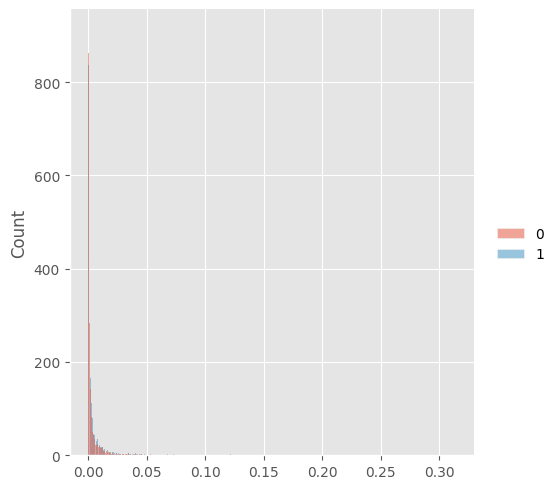

In [23]:
alpha = 0.1
counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                            (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
print(np.min(evidence_smooth))
sns.displot(evidence_smooth)

In [24]:
words_to_index = defaultdict(lambda: -1)
for idx, word in enumerate(words):
    words_to_index[word] = idx

correct, total = 0, 0

answers = []
for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
    this_counts = np.zeros(len(words))
    for word in keywords:
        idx = words_to_index[word]
        if idx != -1:
            this_counts[idx] = 1

    marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
    joint = np.sum(np.log(marginal), axis=0)
    predicted = 'cs' if joint[0] > joint[1] else 'stat'
    answers.append(predicted)
    if predicted == tag:
        correct += 1
    total += 1
test_df.insert(1, "predictions", answers, True)

print("Accuracy:", correct / total)

Accuracy: 0.7641666666666667


# **Questions**

1. In the "Bayes on Text - Classifying papers at Arxiv" section, what preprocessing steps are performed on the Arxiv paper data? Why are these steps necessary?

2. How are probability distributions learned from the Arxiv paper data, and how are these distributions used in the classification of papers into Computer Science (CS) and Statistics (Stat) categories?

3. What is probability smoothing, and why is it necessary in the context of the Bayesian classifier used in this code? How does Laplace smoothing improve the model's performance, and what parameter is involved in Laplace smoothing?

4. The code uses Laplace smoothing with a fixed value of alpha = 0.1. How might you experiment with different values of alpha to observe the impact on classification accuracy? Provide an example of how you would modify the code to test various alpha values.

5. In the "Visualizing the Decision Surface" section, the code visualizes the decision boundary for the Gaussian Naive Bayes classifier. How would you adjust the code to change the size or color of the decision boundary line, and what significance might these changes have?

#Answer

EXERCISE 1

1. Some physics-related categories are grouped under the 'physics' category.
2. Unwanted columns, including "day," "month," "link," and "author," are removed.
3. To balance the number of samples between "cs" and "stat" categories, the dataset is sampled.
4. Data is cleaned by eliminating non-alphanumeric characters and breaking it into individual words.

EXERCISE 2

Probability distributions are built from the Arxiv paper data through the following process:

1. Conditional probabilities are determined to assess the likelihood of a word appearing in either a "cs" paper or a "stat" paper using Bayes' rule.

2. Prior probabilities are computed based on the training data, representing the initial expectations for each category.

3. Evidence probabilities are calculated for both categories, taking into account the frequency of words in the papers.

EXERCISE 3

Probability smoothing is a method employed to assign a non-zero probability to events that may not have been observed in the training data.

Laplace smoothing is a specific form of probability smoothing. It entails adding a small value (alpha) to the counts of each event to prevent any event from having a zero probability.

In this particular situation, Laplace smoothing is not extensively applied, but it is commonly used as it often enhances the model's performance.

EXERCISE 4

3.5367487291400796e-08
3.4812153619071494e-06
0.00013544629554381688


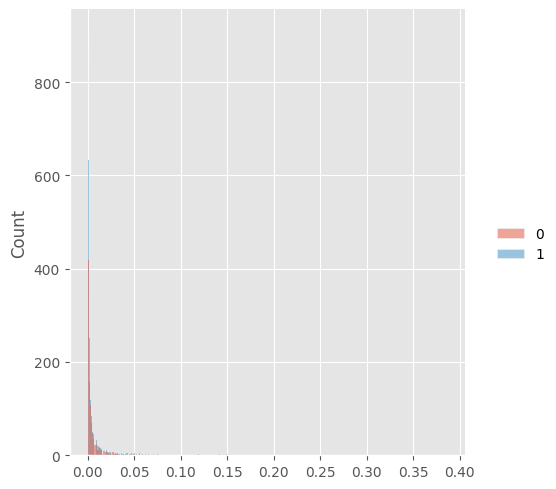

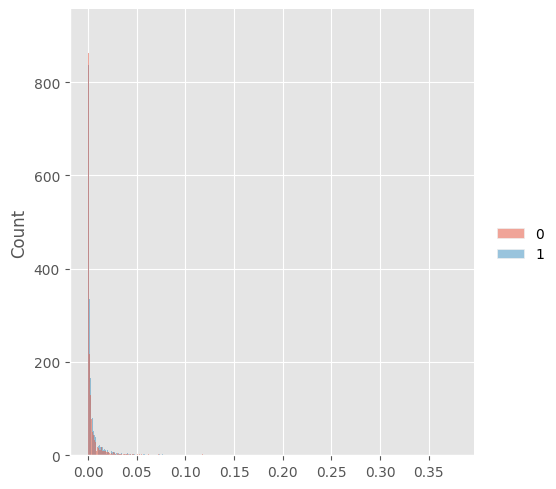

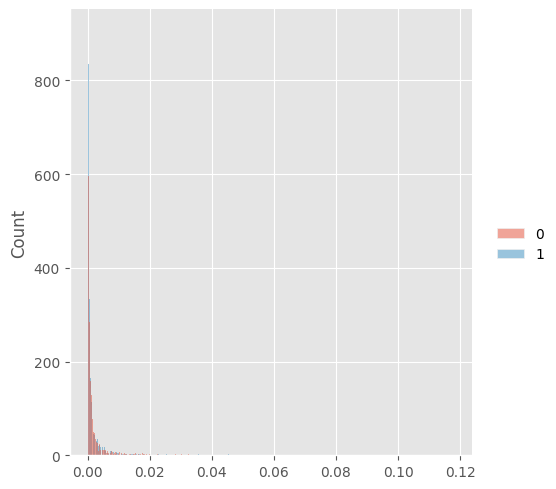

In [25]:
alphas = [0.0001, 0.01, 1.0]

for alpha in alphas:
  counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
  evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                              (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T
  print(np.min(evidence_smooth))
  sns.displot(evidence_smooth)

In [26]:
alphas = [0.0001, 0.01, 1.0]

accuracy_results = {}

for alpha in alphas:
    counts_cs, counts_stat = np.array(counts_cs), np.array(counts_stat)
    evidence_smooth = np.array([(counts_cs + alpha) / (train_df["tag"].value_counts()["cs"] + alpha * len(words)),
                                (counts_stat + alpha) / (train_df["tag"].value_counts()["stat"] + alpha * len(words))]).T

    correct, total = 0, 0
    answers = []

    for tag, keywords in zip(test_df["tag"], test_df["keywords"]):
        this_counts = np.zeros(len(words))
        for word in keywords:
            idx = words_to_index[word]
            if idx != -1:
                this_counts[idx] = 1

        marginal = np.multiply(prior.T, np.divide(np.multiply(this_counts.reshape(-1, 1), evidence_smooth), likelihood.reshape(-1, 1))) + 0.0000001
        joint = np.sum(np.log(marginal), axis=0)
        predicted = 'cs' if joint[0] > joint[1] else 'stat'
        answers.append(predicted)

        if predicted == tag:
            correct += 1
        total += 1

    accuracy = correct / total

    accuracy_results[alpha] = accuracy

    print(f"Alpha = {alpha}: Accuracy = {accuracy}")

Alpha = 0.0001: Accuracy = 0.8116666666666666
Alpha = 0.01: Accuracy = 0.7991666666666667
Alpha = 1.0: Accuracy = 0.625


EXERCISE 5

ax.vlines(0.5, 0, 1750, color="purple", linestyles="--", lw=2a)

ax.vlines(0.7, 0, 1750, color="green", linestyles="--", lw=1)

'color' : Changes the color
'line width : Adjust width of the line.